In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


from xgboost import XGBRegressor

In [13]:
# Video Related Features
df = pd.read_csv('../data/All_data_cbs.csv')
dfNSFW = pd.read_csv('../data/all_virality_nsfw.csv')

In [14]:
dfNSFW.rename(columns={'video_id' : 'Id'}, inplace = True)
df = df[df['channelVideoCount']<2000]
df = df[df['subscriberCount'] >0]
df = df.merge(dfNSFW,on='Id',how='left')
df['nsfw_score'] = df['nsfw_score'].fillna(0)

In [22]:
# Drop tinie tempah
df = df[(df['Channel Id'] != 'UCDSX4RQN7fzIlZ1nSubwCcQ')]

df = df[df['ViewCount'] < 100000]

df['PublishedAt'] = pd.to_datetime(df['PublishedAt'], errors='coerce')
df['PrevPublishedAt'] = pd.to_datetime(df['PrevPublishedAt'], errors='coerce')

df['TimeDiff'] = pd.to_timedelta(df['PublishedAt']).subtract(pd.to_timedelta(df['PrevPublishedAt']))
# Drop some that have negative time diff values
df = df[df['TimeDiff'] > pd.Timedelta(0)]
df['Daysdiff'] = df['TimeDiff'].divide(np.timedelta64(24, 'h'))

df = df[df['PrevViewCount'] > 0]
df = df[df['ViewCount'] > 0]
df['ViewCountDifference'] = df['ViewCount'] - df['PrevViewCount']
df['PercentDifference'] = df['ViewCountDifference'] / df['PrevViewCount']
df = df[np.abs(df['PercentDifference']) < 5]
df['clickbait-difference'] = df['Title-clickbait'] - df['PrevTitle-clickbait']

In [23]:
df.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'rowHash', u'Id', u'Title',
       u'Description', u'LikeCount', u'DislikeCount', u'ViewCount',
       u'FavoriteCount', u'CommentCount', u'PublishedAt', u'Channel Id',
       u'Channel Title', u'Lang', u'publishedAt', u'subscriberCount',
       u'channelVideoCount', u'channelViewCount', u'nextHash',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevPublishedAt', u'PrevViewCount', u'PrevTitle', u'PublishedYear',
       u'ChannelAge', u'Title-clickbait', u'PrevTitle-clickbait',
       u'nsfw_score', u'TimeDiff', u'Daysdiff', u'ViewCountDifference',
       u'PercentDifference', u'clickbait-difference'],
      dtype='object')

In [26]:
feature_list = [
    'subscriberCount', 'channelVideoCount', 'channelViewCount', 'PrevCommentCount',
    'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear', 'ChannelAge',
    'Title-clickbait', 'PrevTitle-clickbait', 'nsfw_score'
]

In [53]:
def r2_cv_score(reg, X, y, cv=4):
    return cross_val_score(reg, X, y, cv=cv, scoring='r2')

def mse_cv_score(reg, X, y, cv=4):
    return -cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_squared_error')

In [50]:
X = df[feature_list]
y = np.log1p(df['ViewCount'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [46]:
reg = XGBRegressor()
r2 = r2_cv_score(reg, X, y)
mse = mse_cv_score(reg, X, y)
print 'R2: {0} +- {1}'.format(r2.mean(), r2.std())
print 'MSE: {0} +- {1}'.format(mse.mean(), mse.std())

R2: 0.752814106392 +- 0.00736574678972
MSE: 0.97859517966 +- 0.021310151227


In [55]:
reg.fit(X_train, y_train)
y_pred = np.exp(reg.predict(X_test))
y_true = np.exp(y_test)
print 'r2 {0}'.format(r2_score(y_pred, y_true))
print 'mse {0}'.format(mean_squared_error(y_pred, y_true))

r2 -1.00923759677
mse 75124625.4399


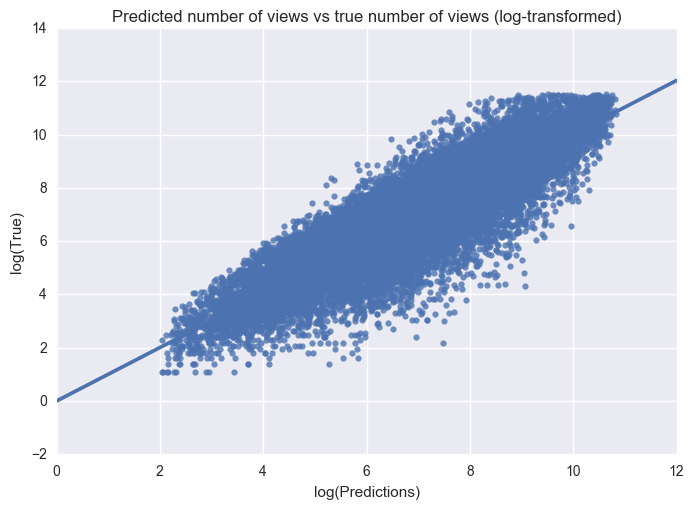

In [64]:
ax = plt.axes()
plt.title('Predicted number of views vs true number of views (log-transformed)')
sns.regplot(np.log1p(y_pred), np.log1p(y_true))
plt.xlabel('log(Predictions)')
plt.ylabel('log(True)')
plt.show()

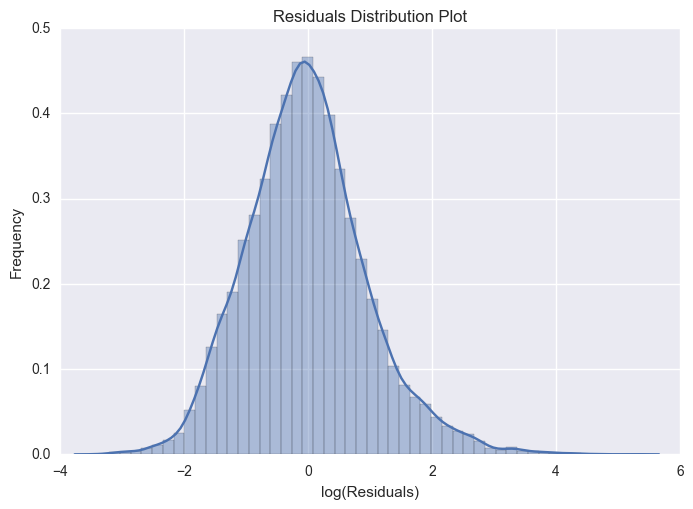

In [66]:
ax = plt.axes()
plt.title('Residuals Distribution Plot')
sns.distplot(np.log1p(y_pred) - np.log1p(y_true))
plt.xlabel('log(Residuals)')
plt.ylabel('Frequency')
plt.show()

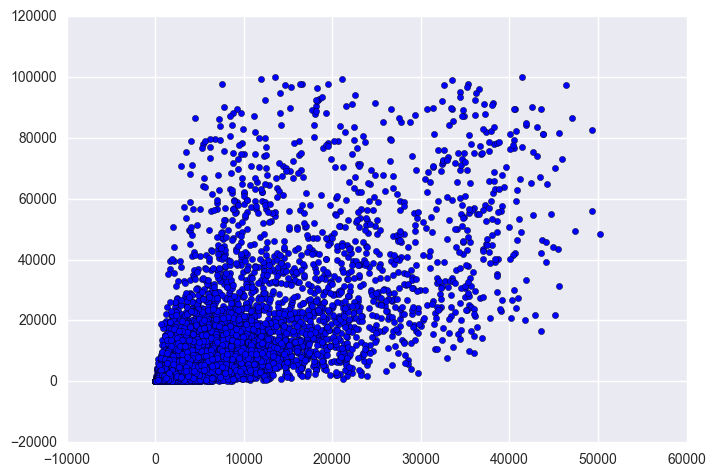

In [58]:
plt.scatter(y_pred, y_true)
plt.show()